# **Question 01: [60 marks]**

Naive Bayes classifiers are a collection of classification algorithms based on Bayes’
Theorem. It is not a single algorithm but a family of algorithms where all of them share
a common principle, i.e. every pair of features being classified is independent of each
other. This question is meant to help you comprehend how a naive bayes classifier
works. \
Download the [Titanic Dataset](https://drive.google.com/file/d/1CAyva1Zalh2NLRFadlluNp7aFLOvoB_C/view) and implementation includes the following tasks:-

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from tqdm import tqdm
import math
import warnings
warnings.filterwarnings("ignore")


1. Perform pre-processing and visualization of the dataset. Split the data into train
and test sets. Also identify the useful columns and drop the unnecessary ones -
[7 marks].

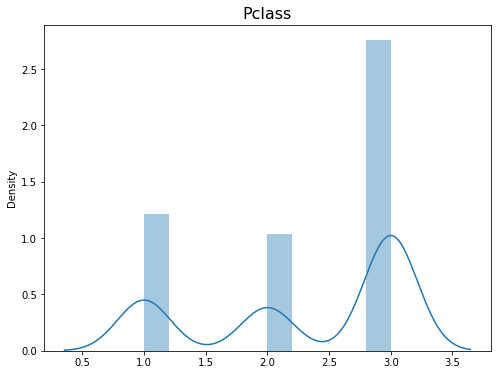

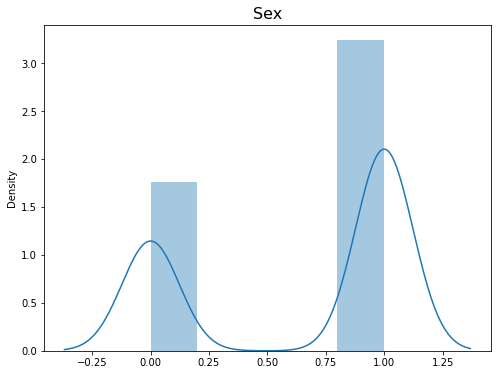

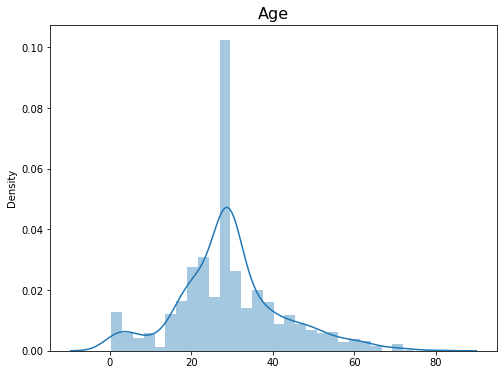

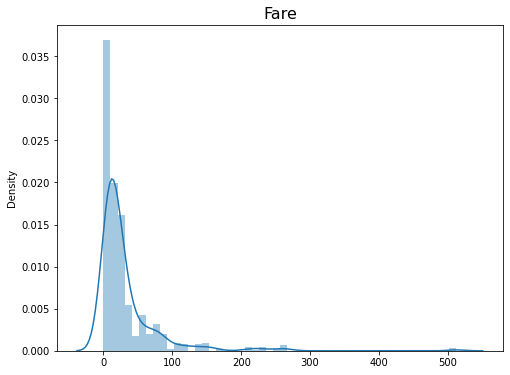

In [230]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Lab 4/titanic.csv')

df.drop(['Cabin','Name','PassengerId','Ticket','Embarked'], axis=1, inplace=True)       # unuseful features : passengerID, name, ticket. embarked
mean_age = int(np.mean(df['Age']))                                                      # too many NA in 'Cabin' feature so dropped, also unuseful
mode_age = max(set(df['Age']),key=list(df['Age']).count)
df['Age'].fillna(mean_age,inplace=True)
df.dropna(inplace=True)
df.reset_index(inplace=True,drop=True)
# print(df.isnull().describe())

LE = preprocessing.LabelEncoder()
df['Sex'] = LE.fit_transform(df['Sex'])

for f in df.columns[:-1]:
    plt.figure(figsize=(8,6))
    plt.title(f,fontsize=16)
    sns.distplot(np.array(df[f]))

Y = df['Survived']
X = df.drop(['Survived'],axis=1)

X_train,X_test,Y_train,Y_test = model_selection.train_test_split(X,Y,test_size=0.2,random_state=41)

X_train.reset_index(drop=True,inplace=True)
Y_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
Y_test.reset_index(drop=True,inplace=True)

2. Identify the best possible variant of naive bayes classifier for the given dataset. Justify your reason for the same - [3 marks].


* Here Age and Fare features have continuous values, and on analysing their distribution plots, we see that they are almost similar to normal distributions, if we ignore some of the initial points.
* We know that for the data following Normal Distributions, we can use Gaussian Naive Bayes Classifier. So, we will use it for classification purpose.



3. Implement the identified variant of Naive Bayes Classifier from scratch. [you may
not use any 3rd-party library's classifier function, such as scikit-learn. However,
Built-in functions, such as train/test split, can be used for supplementary tasks.] -
[20 marks]

In [231]:
class NaiveBayesClassifier():

    def __init__(self):
        self.parameters = []
        self.classes = []
        self.garbage = []

    def calculate_likelihood(self,c,row):
        ds = self.dataset[self.dataset['Survived']==c]
        return self.calculate_evidence(ds,row)
    
    # below code can also be used for the same purpose

    # def calculate_likelihood(self,x_val, mean, var):
    #     zero_eleminator = 0.000001
    #     deno = math.sqrt(2 * math.pi * var + zero_eleminator)
    #     expo = ((x_val - mean)**2) / (2 * var + zero_eleminator)
    #     deno *= math.exp(expo)
    #     return 1.0/deno

    def calculate_evidence(self,ds,row):
        evi = 1.0
        for i,val in enumerate(np.array(row)):
            fvals = list(ds.iloc[:,i])
            cnt = max(fvals.count(val),1)
            evi *= cnt/len(fvals)                
        return evi

    def calculate_prior(self, c):
        return len(df[df['Survived']==c])/len(df)

    def classify(self, sample):
        all_posteriors = []
        for i, c in enumerate(self.classes):
            prior = self.calculate_prior(c)
            likelihood = self.calculate_likelihood(c,sample)
            all_posteriors.append(likelihood*prior)
        evidence = np.sum(all_posteriors)
        all_posteriors/=evidence
        return self.classes[np.argmax(all_posteriors)],all_posteriors
    
    def fit(self, X, Y):
        self.dataset = pd.concat([X,Y],axis=1)
        self.classes = np.unique(np.array(Y))

        for i, c in enumerate(self.classes):

            X_c = self.dataset[self.dataset['Survived']==c]
            self.parameters.append([])

            for col in X_c.columns[:-1]:
                xc_arr = np.array(X_c[col])
                parameters = (np.mean(xc_arr), np.var(xc_arr))
                self.parameters[i].append(parameters)

    def predict(self, X):
        y_pred = []
        y_probabs = []
        for i in range(len(X)):
            row = X.iloc[i,:]
            curr_pred, curr_probabs = self.classify(row)
            y_pred.append(curr_pred)
            y_probabs.append(curr_probabs)
        return pd.Series(y_pred),np.array(y_probabs)

scratch_model = NaiveBayesClassifier()
scratch_model.fit(X_train,Y_train)
Y_pred_scratch, Y_probabs = scratch_model.predict(X_test)

scratch_acc = metrics.accuracy_score(Y_test,Y_pred_scratch)*100



4. Perform 5-fold cross-validation using the entire training feature set - [5 marks]

In [232]:
X_partitions=[pd.DataFrame() for i in range(5)]
Y_partitions=[pd.DataFrame() for i in range(5)]

X_partitions[0]=X_train
Y_partitions[0]=Y_train
for i in range(0,4):
    X_partitions[i], X_partitions[i+1],Y_partitions[i], Y_partitions[i+1] = model_selection.train_test_split(X_partitions[i], Y_partitions[i], test_size=(5-i-1)/(5-i),random_state=41)

best_cv_model = NaiveBayesClassifier()
cv_ytests = []
cv_probabs = []
best_acc = 0
all_acc = []

for i in range(5):
    cv_xtest = X_partitions[i]
    cv_ytest = np.array(Y_partitions[i])
    cv_xtrain = []
    cv_ytrain = []
    for j in range(5):
        if i==j:
            continue
        cv_xtrain.append(X_partitions[j])
        cv_ytrain.append(Y_partitions[j])
    cv_xtrain = pd.concat(cv_xtrain)
    cv_ytrain = pd.concat(cv_ytrain)
    
    curr_model = NaiveBayesClassifier()
    curr_model.fit(cv_xtrain, cv_ytrain)
    cv_ypredicted, cv_probab = curr_model.predict(cv_xtest)
    cv_ytests.append(cv_ytest)
    cv_probabs.append(cv_probab)
    curr_acc = metrics.accuracy_score(cv_ytest,cv_ypredicted)*100
    all_acc.append(curr_acc)

    if curr_acc>best_acc:
        best_acc = curr_acc
        best_cv_model = curr_model
        
print(f'After 5-fold cross-validation, maximum accuracy obtained on validation sets was :\nAccuracy = {best_acc:.2f} %\n')

cv_ypredicted, cv_final_probab = best_cv_model.predict(X_test)
acc_test = metrics.accuracy_score(Y_test, np.ravel(cv_ypredicted))*100

print('Metrics of price predictions on Testing data :')
print(f'Accuracy = {acc_test:.2f} %')


After 5-fold cross-validation, maximum accuracy obtained on validation sets was :
Accuracy = 79.02 %

Metrics of price predictions on Testing data :
Accuracy = 78.77 %



5. Visualize and summarize the results across the cross-validation sets. Compute
the probability of the top class for each row in the testing dataset. - [5 + 5 marks]

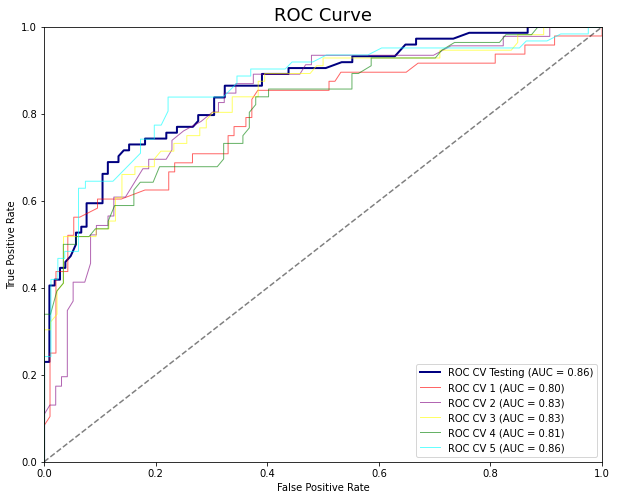

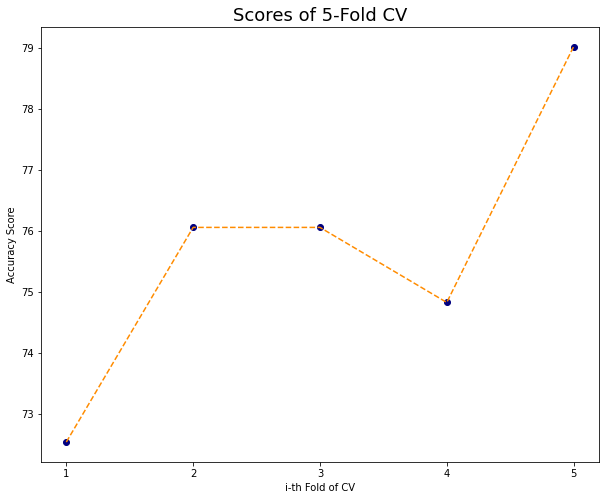


Top class probabbilities :



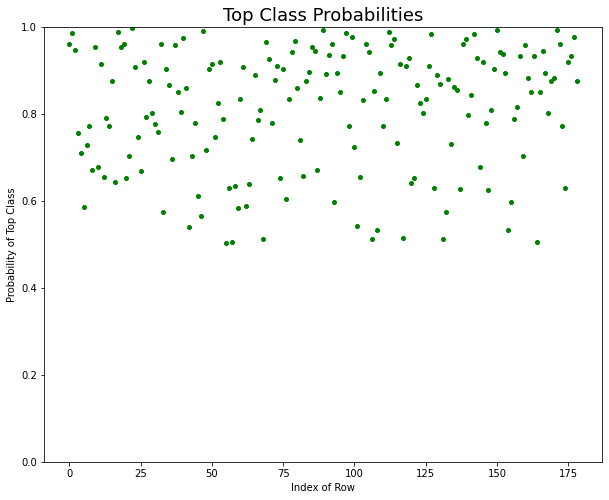

In [233]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(Y_test, cv_final_probab[:,1])
roc_auc = auc(fpr, tpr)

colors = ['red','purple','yellow','green','cyan']

plt.figure(figsize=(10,8))
plt.plot(fpr,tpr,color="navy",lw=2,label=f"ROC CV Testing (AUC = {roc_auc:0.2f})")
for i in range(1,6):
    cfpr, ctpr, _ = roc_curve(cv_ytests[i-1], cv_probabs[i-1][:,1])
    croc_auc = auc(cfpr, ctpr)
    plt.plot(cfpr,ctpr,color=colors[i-1],lw=1,label=f"ROC CV {i} (AUC = {croc_auc:0.2f})",alpha=0.6)

plt.plot([0, 1], [0, 1], color="black",linestyle='--',alpha=0.5)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve",fontsize=18)
plt.legend(loc="lower right")
plt.show()


plt.figure(figsize=(10,8))
plt.plot([str(x) for x in range(1,6)],all_acc,c='darkorange',linestyle='--')
plt.scatter([str(x) for x in range(1,6)],all_acc,c='navy')
plt.xlabel('i-th Fold of CV')
plt.ylabel('Accuracy Score')
plt.title('Scores of 5-Fold CV',fontsize=18)
plt.show()

def top_class_p(all_probabs):
    l = []
    for i in all_probabs:
        l.append(max(i))
    l = np.array(l)
    return l

class_probs = top_class_p(cv_final_probab)
print('\nTop class probabbilities :\n')
plt.figure(figsize=(10,8))
plt.plot(range(len(class_probs)),class_probs,'go',markersize=4)
plt.xlabel('Index of Row')
plt.ylabel('Probability of Top Class')
plt.title('Top Class Probabilities',fontsize=18)
plt.ylim(0,1)
plt.show()


6. Compare your scratch implementation with scikit-learn in terms of the
performance - [5 marks]

In [234]:
from sklearn.naive_bayes import GaussianNB

MODEL = GaussianNB().fit(X_train,Y_train)
Y_preds_sk = MODEL.predict(X_test)

sk_acc = metrics.accuracy_score(Y_test,Y_preds_sk)*100

print()
print(f'Accuracy score = {scratch_acc:.2f} %\t\t[Gaussian Naive Bayes from scratch]')
print(f'Accuracy score = {sk_acc:.2f} %\t\t[Gaussian Naive Bayes sklearn]')


Accuracy score = 79.33 %		[Gaussian Naive Bayes from scratch]
Accuracy score = 84.36 %		[Gaussian Naive Bayes sklearn]



7. Implement any other model of your choice [not necessarily from scratch] and
perform 5-fold cross-validation and summarize the results. Compare it with the
Naive Bayes Classifier you have implemented and justify your results - [10 marks] 

In [235]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier()
cv_scores = cross_val_score(DTC, X_train, Y_train, cv=KFold(5))
avg_cv_acc = np.mean(cv_scores)*100

print()
print(f'    Accuracy score = {scratch_acc:.2f} %\t\t[Gaussian Naive Bayes from scratch]')
print(f'Avg Accuracy score = {avg_cv_acc:.2f} %\t\t[Decision Tree Classifier after 5-fold CV]')


    Accuracy score = 79.33 %		[Gaussian Naive Bayes from scratch]
Avg Accuracy score = 77.24 %		[Decision Tree Classifier after 5-fold CV]


# **Question 02: [40 Marks]**
Only Numpy, Pandas, Seaborn and Matplotlib are allowed.

Dataset - [Link](https://drive.google.com/file/d/1BCLY3pCIH7kTuXKsEL7IxCRD3VoLkhk4/view) \

There are 210 rows with 7 input variables and 1 output variable. The variable names are as given:
1. Area.
2. Perimeter.
3. Compactness
4. Length of kernel.
5. Width of kernel.
6. Asymmetry coefficient.
7. Length of kernel groove.
8. Class (1, 2, 3).

In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from tqdm import tqdm
import math
import warnings
warnings.filterwarnings("ignore")

text_data = ""
with open('/content/drive/MyDrive/Colab Notebooks/Lab 4/dataset.txt','r') as f:
    text_data = f.read()
    
csv_data = 'Area,Perimeter,Compactness,Length of kernel,Width of kernel,Asymmetry coefficient,Length of kernel groove,Class\n'
csv_data += text_data.replace('\t',',')
csv_data = csv_data.replace(',,',',')

with open('/content/drive/MyDrive/Colab Notebooks/Lab 4/dataset.csv','w') as f:
    f.write(csv_data)

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Lab 4/dataset.csv')
df.head(6)

,Area,Perimeter,Compactness,Length of kernel,Width of kernel,Asymmetry coefficient,Length of kernel groove,Class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
5,14.38,14.21,0.8951,5.386,3.312,2.462,4.956,1


a. Use histogram to plot the distribution of samples. [3 marks]

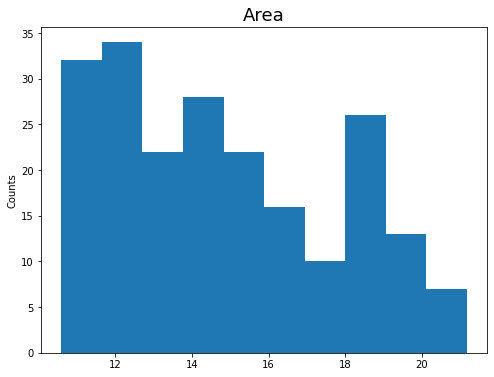

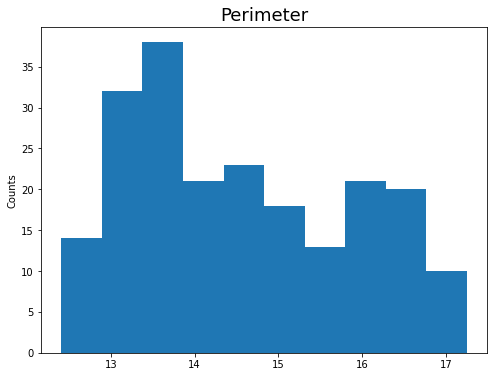

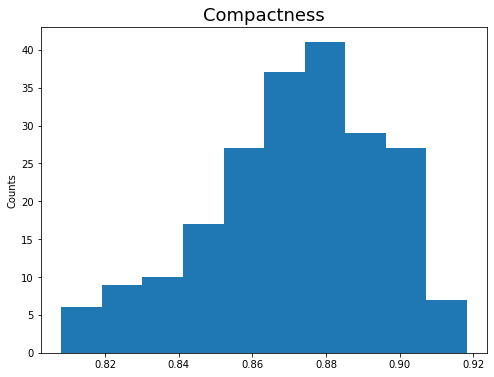

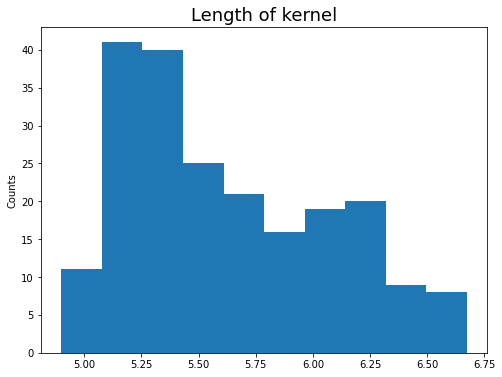

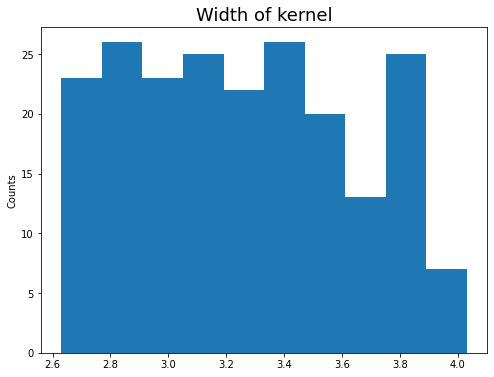

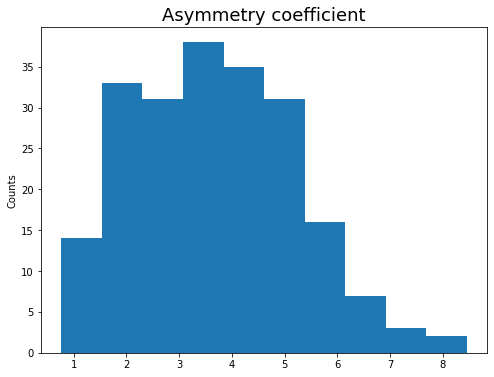

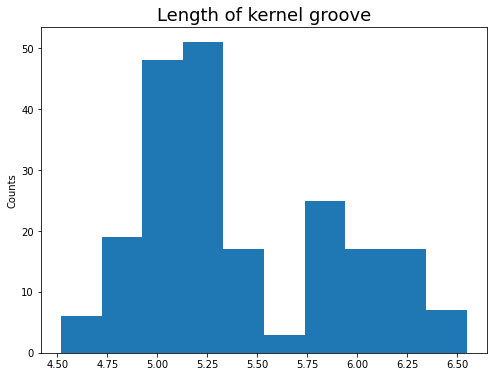

In [237]:
for f in df.columns[:-1]:
    plt.figure(figsize=(8,6))
    plt.title(f,fontsize=18)
    plt.ylabel('Counts')
    plt.hist(df[f])
    plt.show()


b. Determine the prior probability for all the classes. [3 marks ]

In [238]:
classes = np.unique(df['Class'])
priors = {}

for c in classes:
    priors[c]=len(df[df['Class']==c])/len(df)

print('Prior Probability for all the classes are :\n')
for i in priors:
    print(f'Class {i} : {priors[i]}')

Prior Probability for all the classes are :

Class 1 : 0.3333333333333333
Class 2 : 0.3333333333333333
Class 3 : 0.3333333333333333



c. Discretize the features into bins from scratch. Use of pandas, scikit learn and
scipy is not allowed for this subpart. [12 marks]

In [239]:
dataset = dict(df)

for f in dataset:
    col_data = list(dataset[f])
    unq = len(set(col_data))
    if unq<=10:
        dataset[f] = np.array(col_data)
        continue

    mn = np.min(col_data)
    mx = np.max(col_data)
    bin_size = (mx-mn)/10

    col = []
    for i in col_data:
        col.append(math.ceil((i-mn)/bin_size))
    dataset[f]=np.array(col)


d. Determine the likelihood/class conditional probabilities for all the classes. [9
marks]

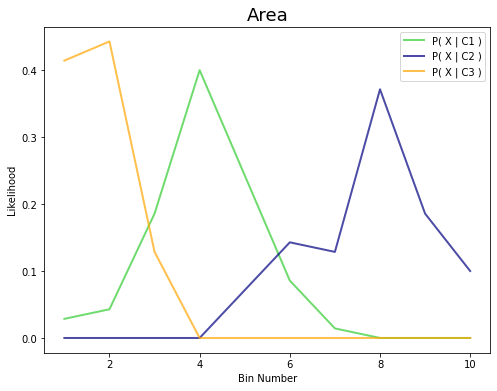

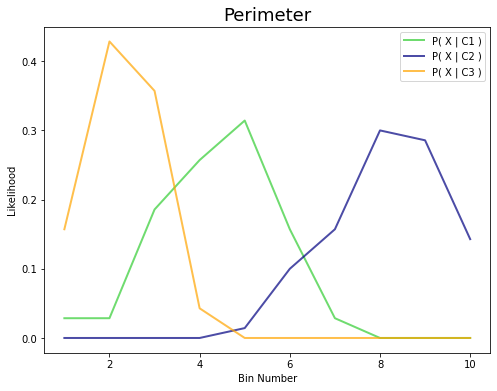

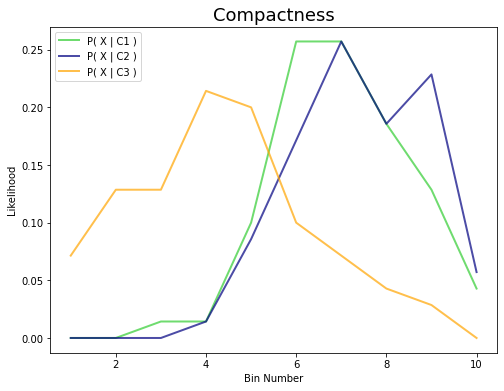

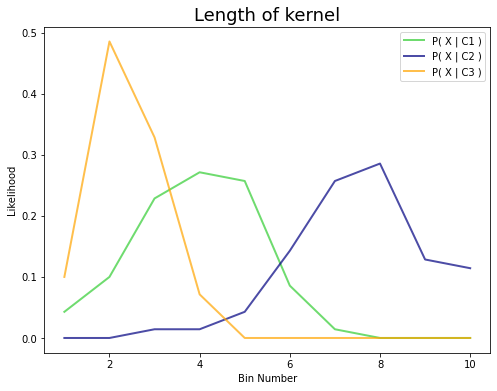

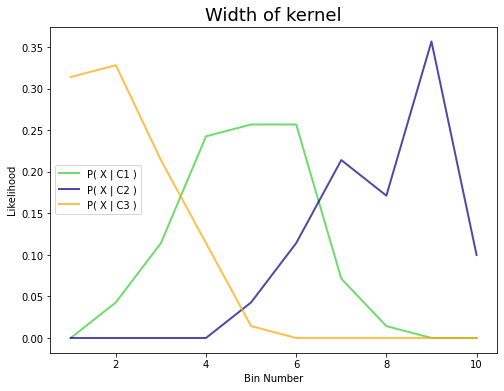

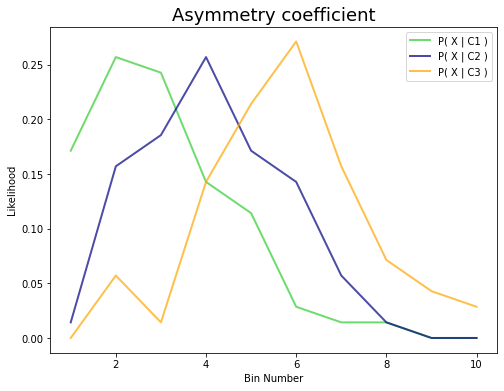

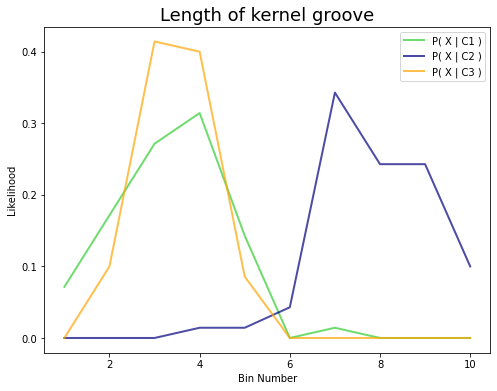

In [240]:
ds = pd.DataFrame(dataset)

classes = list(set(ds['Class']))
likelihoods = {}

for c in classes:
    d={}
    cds = ds[ds['Class']==c]
    for f in ds.columns[:-1]:
        arr = []
        for ix in range(1,11):
            arr.append(len(cds[cds[f]==ix])/len(cds))
        d[f]=np.array(arr)
    likelihoods[c] = pd.DataFrame(d)

# for i in likelihoods:
#     print(f'Class {i}')
#     print(likelihoods[i])
#     print()
for f in ds.columns[:-1]:
    plt.figure(figsize=(8,6))
    plt.title(f,fontsize=18)
    plt.plot([x for x in range(1,11)],likelihoods[1][f],label='P( X | C1 )',lw=2,color='limegreen',alpha=0.7)
    plt.plot([x for x in range(1,11)],likelihoods[2][f],label='P( X | C2 )',lw=2,color='navy',alpha=0.7)
    plt.plot([x for x in range(1,11)],likelihoods[3][f],label='P( X | C3 )',lw=2,color='orange',alpha=0.7)
    plt.xlabel('Bin Number')
    plt.ylabel('Likelihood')
    plt.legend()
    plt.show()


e. Plot the count of each unique element for each class. Compare the plot with the
plot of distribution. [3 marks]

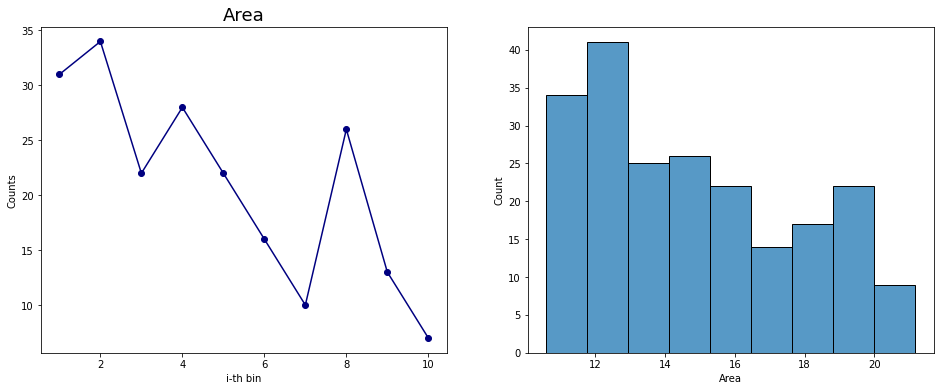

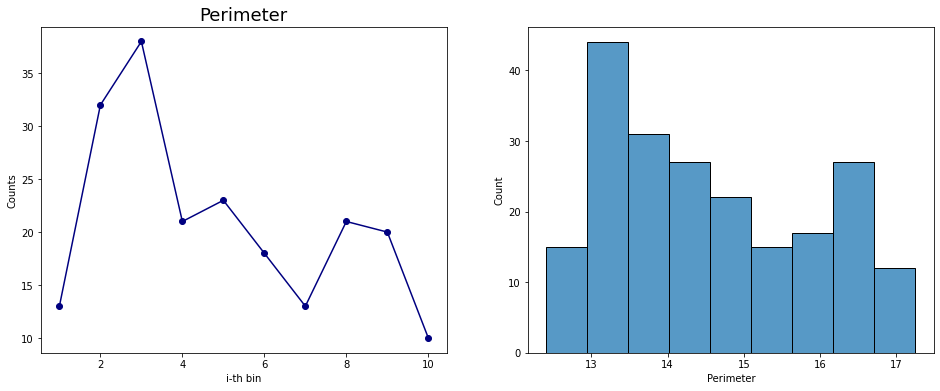

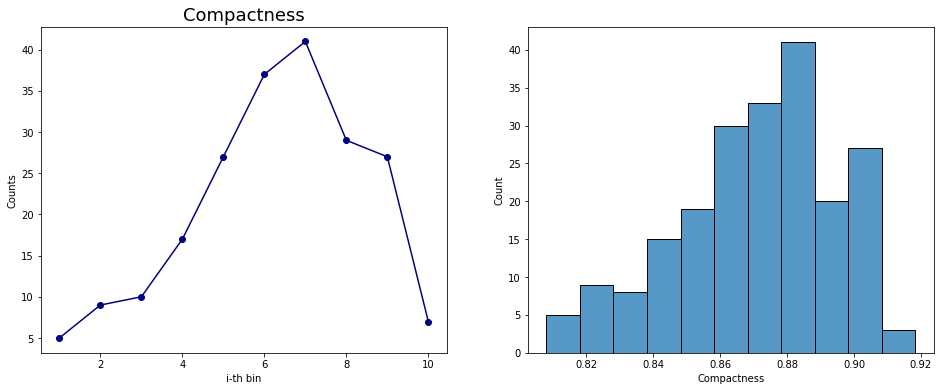

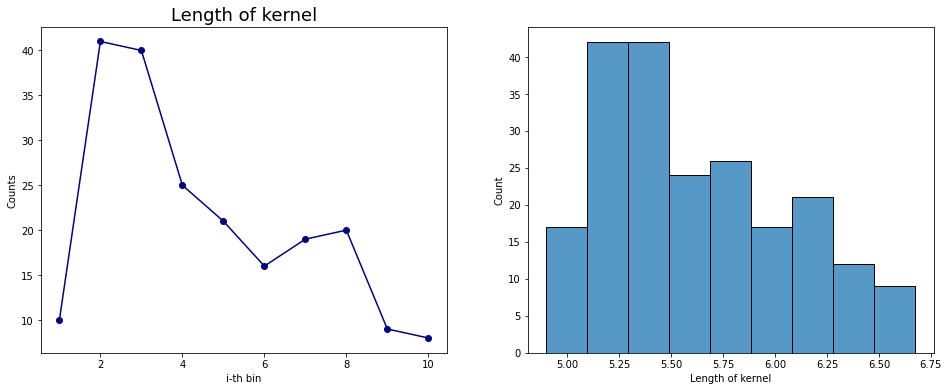

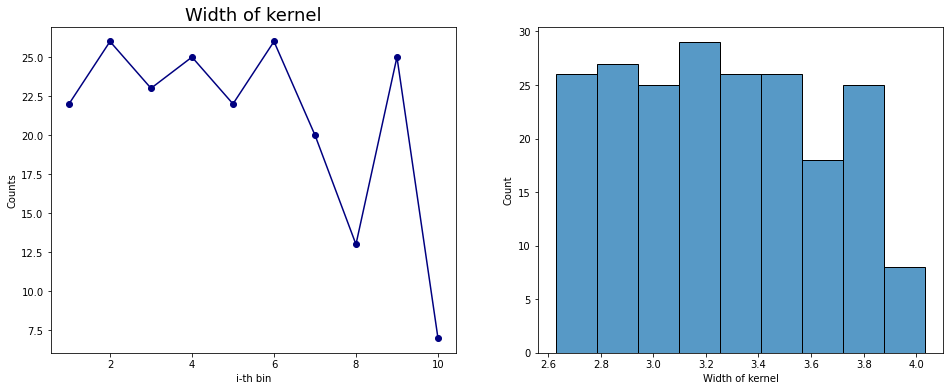

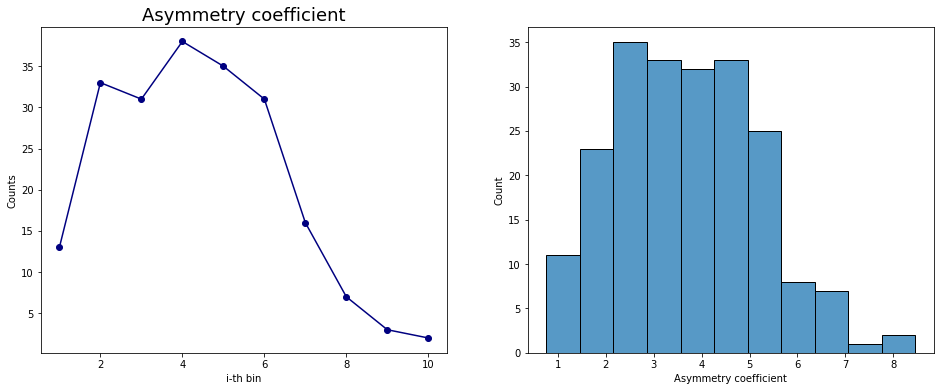

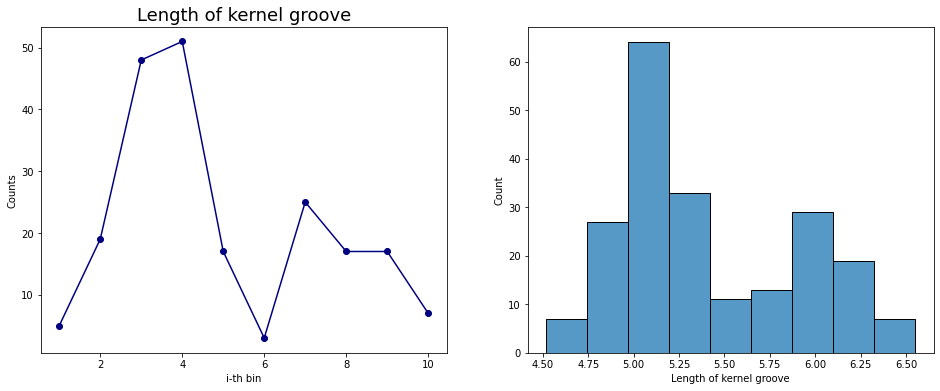

In [241]:
datacounts = {}


for f in ds.columns[:-1]:
    arr = []
    for ix in range(1,11):
        arr.append(len(ds[ds[f]==ix]))
    datacounts[f]=np.array(arr)

for f in datacounts:
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(range(1,11),datacounts[f],'navy',marker='o')
    plt.title(f,fontsize=18)
    plt.ylabel('Counts')
    plt.xlabel('i-th bin')

    plt.subplot(1,2,2)
    sns.histplot(df[f])
    plt.show()


f. Calculate the posterior probabilities and plot them in a single graph. Analyse the
plot. [10 marks]

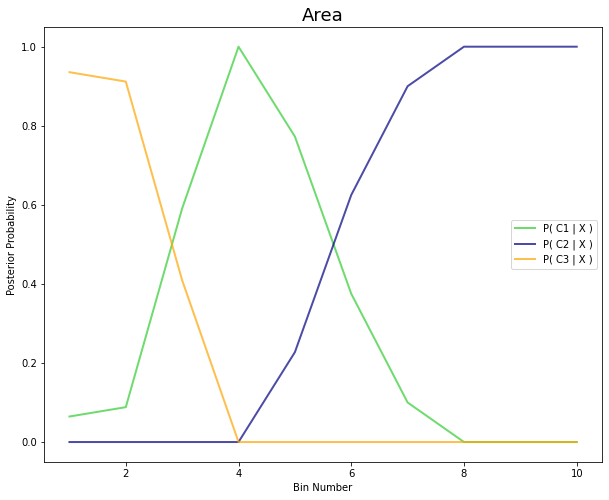

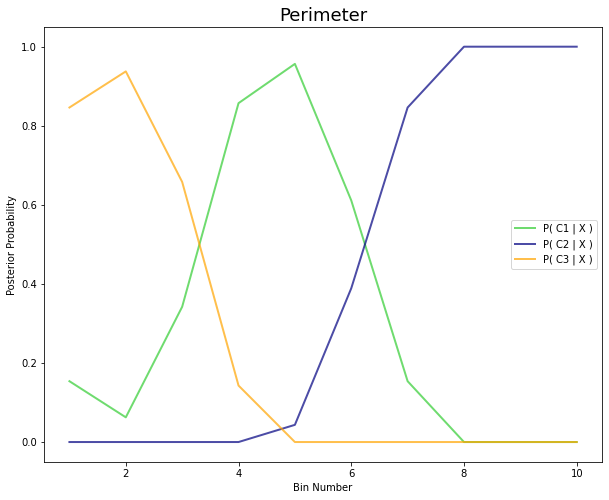

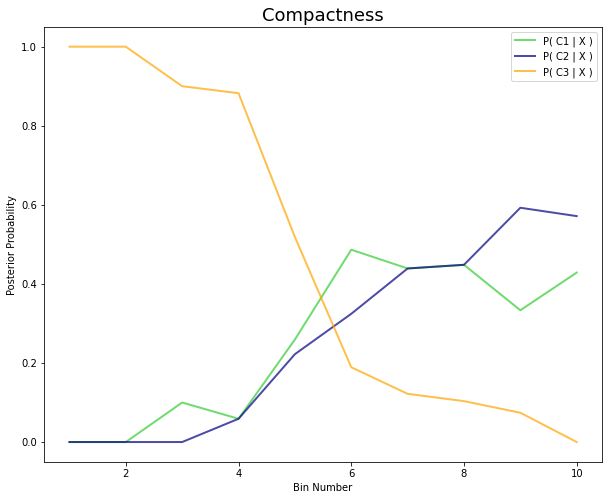

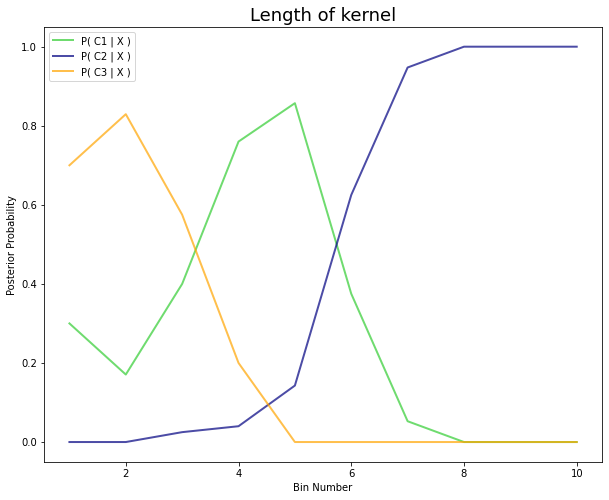

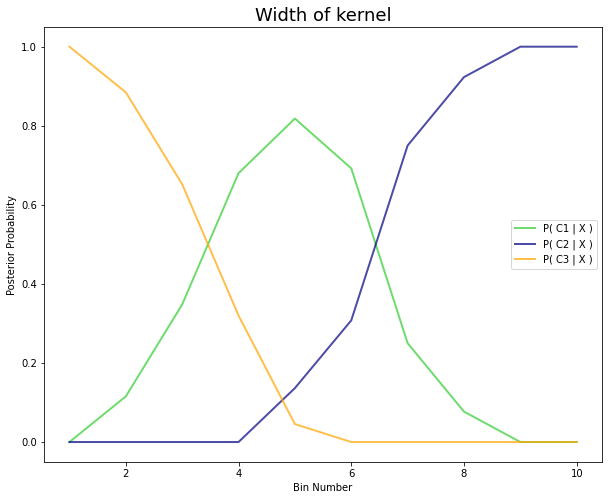

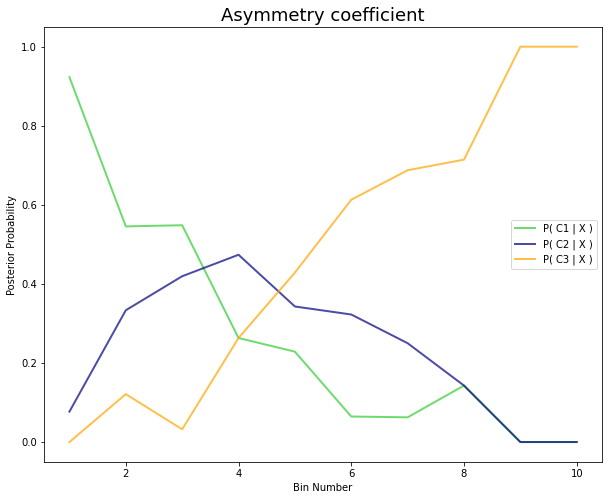

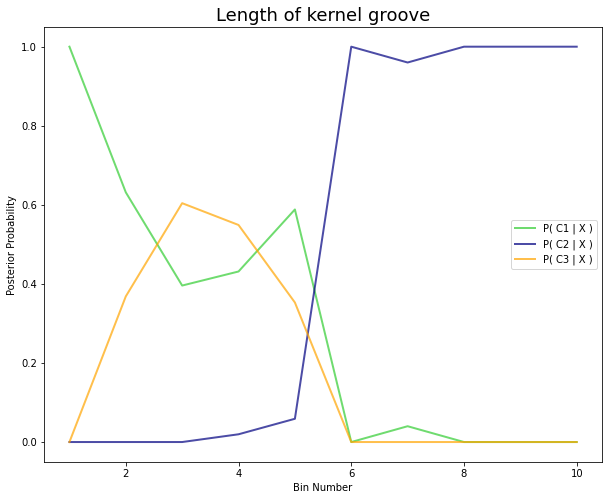

In [242]:
posteriors = {}

for f in ds.columns[:-1]:
    arr = []
    for c in classes:
        arr.append(np.array(likelihoods[c][f]*priors[c]))
    for i in range(len(arr[0])):
        sm=0
        for j in range(3):
            sm+=arr[j][i]
        for j in range(3):
            arr[j][i]/=sm

    posteriors[f]=arr

for f in posteriors:
    plt.figure(figsize=(10,8))
    plt.title(f,fontsize=18)
    plt.plot([x for x in range(1,11)],posteriors[f][0],label='P( C1 | X )',lw=2,color='limegreen',alpha=0.7)
    plt.plot([x for x in range(1,11)],posteriors[f][1],label='P( C2 | X )',lw=2,color='navy',alpha=0.7)
    plt.plot([x for x in range(1,11)],posteriors[f][2],label='P( C3 | X )',lw=2,color='orange',alpha=0.7)
    plt.xlabel('Bin Number')
    plt.ylabel('Posterior Probability')
    plt.legend()
    plt.show()